In [1]:
from glob import glob
import sys
import os
# import psutil
from os.path import join, dirname
from os.path import getsize
import pickle
import numpy as np
import pandas as pd
import scipy.stats

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.multitest
# from statsmodels.sandbox.stats.multicomp import multipletests

# import nilearn.masking
from nilearn import plotting as nplt
from nilearn import image as niimg
import nilearn.decoding

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
# from sklearn.svm import LinearSVC

# import mydef_GA as my
import mydef

%matplotlib inline

In [2]:
from datetime import date
today = date.today().strftime("%Y%m%d")

In [3]:
GA = mydef.GA()

In [4]:
## background image
img_bg = join(GA.dir_mask,'mni152_2009bet.nii.gz')

# ROI list

## Movement-related ROIs from localizer

In [5]:
## ROI
roi_imgs = {}
path_list = sorted(glob(join(GA.dir_mask,'localizer','n200_*.nii')))
for path in path_list:
    roi = path.split('/')[-1].replace('_mask.nii', '')
    roi_imgs[roi] = niimg.load_img(path)
roi_imgs

{'n200_c1-1_L_M1': <nibabel.nifti1.Nifti1Image at 0x7fdd97c340d0>,
 'n200_c1-2_L_S1': <nibabel.nifti1.Nifti1Image at 0x7fdd9c0b08e0>,
 'n200_c1_L_Postcentral': <nibabel.nifti1.Nifti1Image at 0x7fdd9c0b0d30>,
 'n200_c1_R_SPL': <nibabel.nifti1.Nifti1Image at 0x7fdd9c0b0c40>,
 'n200_c2_R_CerebellumIV-V': <nibabel.nifti1.Nifti1Image at 0x7fdd9c0e0400>,
 'n200_c2_R_MFG': <nibabel.nifti1.Nifti1Image at 0x7fdd9c0e07c0>,
 'n200_c3_R_MTG': <nibabel.nifti1.Nifti1Image at 0x7fdd9c0e0940>,
 'n200_c3_R_Postcentral': <nibabel.nifti1.Nifti1Image at 0x7fdd9c0e0fa0>,
 'n200_c4_L_IFG': <nibabel.nifti1.Nifti1Image at 0x7fdd9c0e41f0>,
 'n200_c4_L_Putamen': <nibabel.nifti1.Nifti1Image at 0x7fdd9c0e4640>,
 'n200_c5_L_SPL': <nibabel.nifti1.Nifti1Image at 0x7fdd9c0b0b80>,
 'n200_c5_R_SMA': <nibabel.nifti1.Nifti1Image at 0x7fdd9c0e0700>,
 'n200_c6_R_CerebellumVIIIb': <nibabel.nifti1.Nifti1Image at 0x7fdd9c0e4820>,
 'n200_c6_R_MFG': <nibabel.nifti1.Nifti1Image at 0x7fdd9c0e4c40>,
 'n200_c7_L_Thalamus': <nibabel

In [6]:
key_list = ['n200_c1_L_Postcentral'
            , 'n200_c2_R_CerebellumIV-V'
            , 'n200_c3_R_Postcentral'
            , 'n200_c4_L_Putamen'
            , 'n200_c5_R_SMA'
            , 'n200_c6_R_CerebellumVIIIb'
            , 'n200_c7_L_Thalamus']
temp = {}
for key in key_list:
    temp[key] = roi_imgs[key]
roi_imgs = temp

n200_c1_L_Postcentral(n_voxles=200)
n200_c2_R_CerebellumIV-V(n_voxles=200)
n200_c3_R_Postcentral(n_voxles=200)
n200_c4_L_Putamen(n_voxles=200)
n200_c5_R_SMA(n_voxles=200)
n200_c6_R_CerebellumVIIIb(n_voxles=200)
n200_c7_L_Thalamus(n_voxles=200)


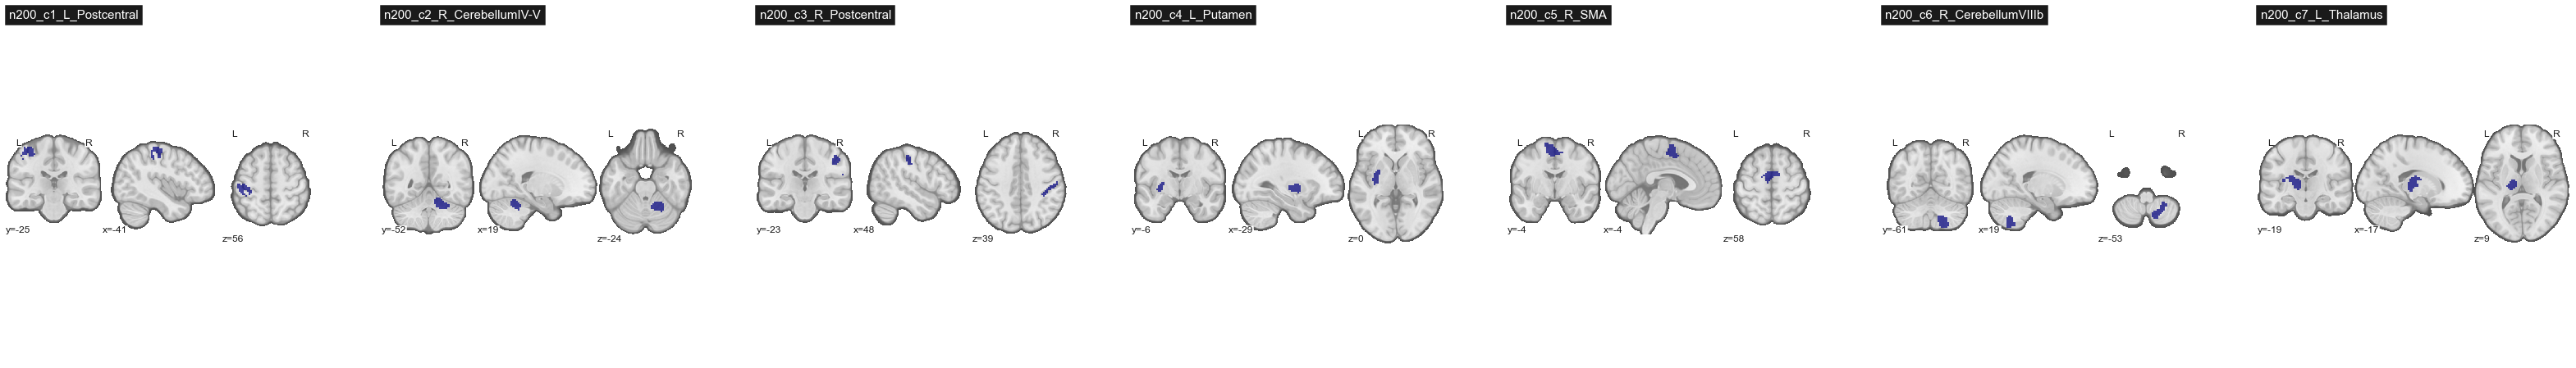

In [7]:
magn = 8   # a size of figures
ncol = 7   # a number of columns

nrow = len(key_list)//ncol   # a number of rows
_, axes = plt.subplots(nrow,ncol,figsize=(ncol*magn,nrow*magn))

for i, (key, img) in enumerate(roi_imgs.items()):
#     print(key, end='\r')
    print('%s(n_voxles=%d)'%(key,img.get_fdata().sum()))
    nplt.plot_roi(roi_img=img, bg_img=img_bg, title=key
                  , draw_cross=False, black_bg=False
                  , display_mode='ortho', axes=axes[i])

## My replicated ROIs from localizers

In [15]:
## ROI
roi_imgs = {}
path_list = sorted(glob(join(stats_dir,'GLM.move-stop','n*.nii.gz')))
for path in path_list:
    roi = path.split('/')[-1].replace('_mask.nii', '')
    roi_imgs[roi] = niimg.load_img(path)
roi_imgs

{'n200.L_Thalamus.nii.gz': <nibabel.nifti1.Nifti1Image at 0x7fba72ed2e20>,
 'n200.R_CerebellumVIIIb.nii.gz': <nibabel.nifti1.Nifti1Image at 0x7fba72ed2d60>,
 'n200.R_Postcentral.nii.gz': <nibabel.nifti1.Nifti1Image at 0x7fba72ed92e0>,
 'n201.L_Postcentral.nii.gz': <nibabel.nifti1.Nifti1Image at 0x7fba72ed9670>,
 'n202.R_CerebellumIV-V.nii.gz': <nibabel.nifti1.Nifti1Image at 0x7fba72ed9a00>,
 'n202.S_SMA.nii.gz': <nibabel.nifti1.Nifti1Image at 0x7fba72ed9df0>,
 'n225.L_Putamen.nii.gz': <nibabel.nifti1.Nifti1Image at 0x7fba72eda490>}

n200.L_Thalamus.nii.gz(n_voxles=1400)
n200.R_CerebellumVIIIb.nii.gz(n_voxles=1200)
n200.R_Postcentral.nii.gz(n_voxles=600)
n201.L_Postcentral.nii.gz(n_voxles=201)
n202.R_CerebellumIV-V.nii.gz(n_voxles=404)
n202.S_SMA.nii.gz(n_voxles=1010)
n225.L_Putamen.nii.gz(n_voxles=900)


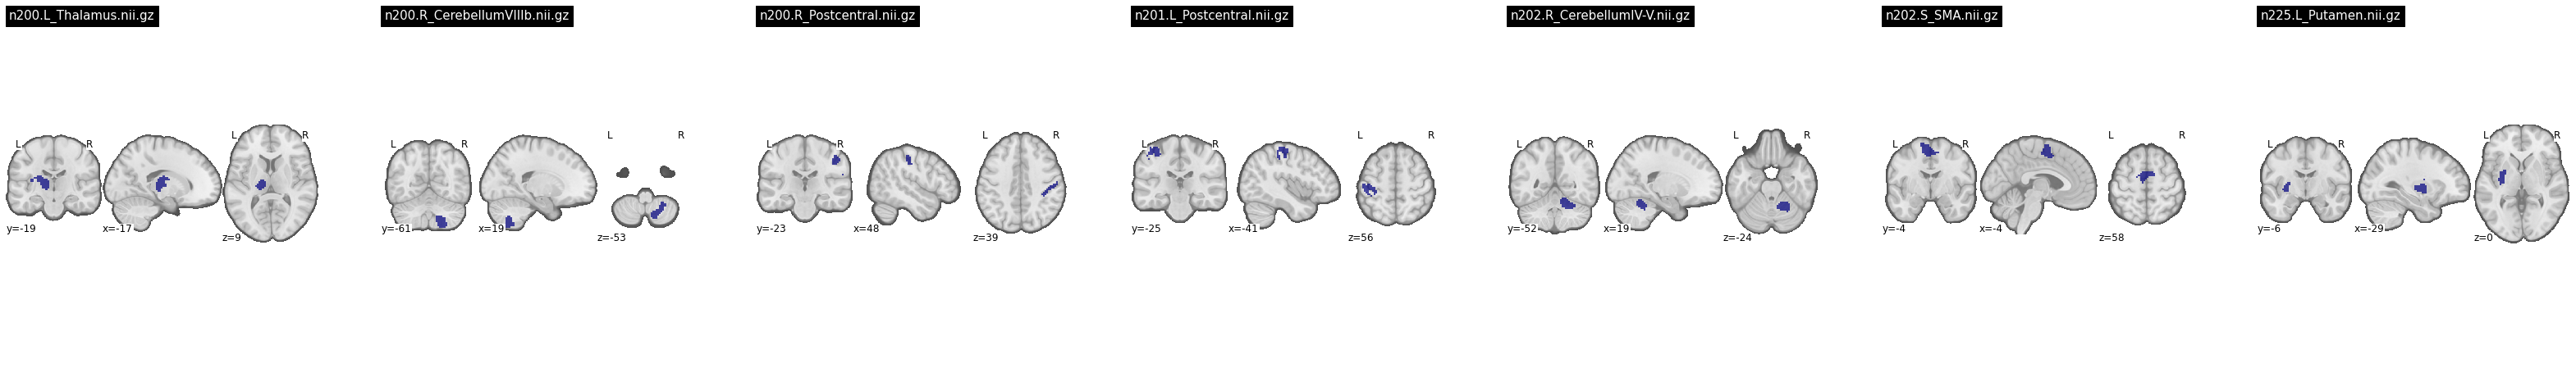

In [17]:
magn = 8   # a size of figures
ncol = 7   # a number of columns

nrow = len(key_list)//ncol   # a number of rows
_, axes = plt.subplots(nrow,ncol,figsize=(ncol*magn,nrow*magn))

for i, (key, img) in enumerate(roi_imgs.items()):
#     print(key, end='\r')
    print('%s(n_voxles=%d)'%(key,img.get_fdata().sum()))
    nplt.plot_roi(roi_img=img, bg_img=img_bg, title=key
                  , draw_cross=False, black_bg=False
                  , display_mode='ortho', axes=axes[i])

## Default Mode Network

In [9]:
roi_imgs = {}
roi_names = []

## DMN regions(global)
module_names = ['Core', 'dMsub', 'MTLsub']

for name in module_names:
    DMN_list = glob(join(dmn_dir, name+'.nii'))
    for path in DMN_list:
        fname = path.split('/')[-1].replace('.nii', '')
        roi_imgs[fname] = nilearn.image.load_img(path)
        roi_names.append(fname)
        
# ## DMN regions(detail)
module_names = ['Core', 'dMsub', 'MTLsub']

for name in module_names:
    DMN_list = glob(join(dmn_dir, name+'_*.nii'))
    for path in DMN_list:
        fname = path.split('/')[-1].replace('.nii', '')
        roi_imgs[fname] = nilearn.image.load_img(path)
        roi_names.append(fname)

roi_imgs

{'Core': <nibabel.nifti1.Nifti1Image at 0x7fb1508c9e20>,
 'dMsub': <nibabel.nifti1.Nifti1Image at 0x7fb140f282e0>,
 'MTLsub': <nibabel.nifti1.Nifti1Image at 0x7fb140f28400>,
 'Core_PCC_l': <nibabel.nifti1.Nifti1Image at 0x7fb140f286a0>,
 'Core_PCC_r': <nibabel.nifti1.Nifti1Image at 0x7fb140f28a60>,
 'Core_aMPFC_l': <nibabel.nifti1.Nifti1Image at 0x7fb140f28e20>,
 'Core_aMPFC_r': <nibabel.nifti1.Nifti1Image at 0x7fb140f19280>,
 'dMsub_LTC_l': <nibabel.nifti1.Nifti1Image at 0x7fb140f19610>,
 'dMsub_LTC_r': <nibabel.nifti1.Nifti1Image at 0x7fb140f19a30>,
 'dMsub_TPJ_l': <nibabel.nifti1.Nifti1Image at 0x7fb140f195e0>,
 'dMsub_TPJ_r': <nibabel.nifti1.Nifti1Image at 0x7fb140f24160>,
 'dMsub_TempP_l_temp': <nibabel.nifti1.Nifti1Image at 0x7fb140f24520>,
 'dMsub_TempP_r_temp': <nibabel.nifti1.Nifti1Image at 0x7fb140f28340>,
 'dMsub_dMPFC': <nibabel.nifti1.Nifti1Image at 0x7fb140f283d0>,
 'MTLsub_HF_l': <nibabel.nifti1.Nifti1Image at 0x7fb140f24130>,
 'MTLsub_HF_r': <nibabel.nifti1.Nifti1Image 

## Ventral visual stream (TT_Daemon, Brodmann Area)

In [10]:
roi_imgs = {}
path_list = glob(join(mask_dir, 'TT_Daemon', '*.brik1.BA???.*.nii.gz'))
for path in path_list:
    temp = path.split('/')[-1].replace('.nii.gz', '')
    fname = temp.split('.')[2]
    roi_imgs[fname] = nilearn.image.load_img(path)
roi_imgs

{'BA17L': <nibabel.nifti1.Nifti1Image at 0x7fb140f0f640>,
 'BA17R': <nibabel.nifti1.Nifti1Image at 0x7fb140f0f490>,
 'BA18L': <nibabel.nifti1.Nifti1Image at 0x7fb140f0fbe0>,
 'BA18R': <nibabel.nifti1.Nifti1Image at 0x7fb140f32a30>,
 'BA19L': <nibabel.nifti1.Nifti1Image at 0x7fb140f32d30>,
 'BA19R': <nibabel.nifti1.Nifti1Image at 0x7fb140f37370>,
 'BA20L': <nibabel.nifti1.Nifti1Image at 0x7fb140f37700>,
 'BA20R': <nibabel.nifti1.Nifti1Image at 0x7fb140f37a90>,
 'BA37L': <nibabel.nifti1.Nifti1Image at 0x7fb140f37eb0>,
 'BA37R': <nibabel.nifti1.Nifti1Image at 0x7fb140f3f070>,
 'BA38L': <nibabel.nifti1.Nifti1Image at 0x7fb140f3f580>,
 'BA38R': <nibabel.nifti1.Nifti1Image at 0x7fb140f3f910>}

## Fan280

In [11]:
fan_imgs={}
path_list = glob(join(mask_dir,'fan280','*.nii.gz'))
for path in path_list:
    temp = path.split('/')[-1].replace('.nii.gz', '')
    fname = temp.split('.')[-1]
    fan_imgs[fname] = nilearn.image.load_img(path)

# The Classification Accuracies of the above ROIs

In [8]:
for subj in GA.list_subj:
    betas = {}    ## memory reduction
    for stage in GA.list_stage:
        beta = GA.load_beta(subj, stage)
        betas[subj, stage] = beta[subj, stage]
    GA.cross_valid(betas, roi_imgs, GA.lda)

# ## save the result
# pickle_name = 'visual_stream'
# with open(join(script_dir, today+'_%s.pkl'%pickle_name),"wb") as fw:
#     pickle.dump(scores, fw)

In [9]:
GA.make_wit_score()

,subj,ROI,visit,mapping,accuracy_1,accuracy_2,accuracy_3,mean_accuracy
0,01,n200_c1_L_Postcentral,early,practice,0.322917,0.427083,0.385417,0.378472
1,01,n200_c2_R_CerebellumIV-V,early,practice,0.239583,0.218750,0.322917,0.260417
2,01,n200_c3_R_Postcentral,early,practice,0.312500,0.291667,0.333333,0.312500
3,01,n200_c4_L_Putamen,early,practice,0.250000,0.322917,0.208333,0.260417
4,01,n200_c5_R_SMA,early,practice,0.333333,0.322917,0.354167,0.336806
...,...,...,...,...,...,...,...,...
835,44,n200_c3_R_Postcentral,late,unpractice,0.281250,0.322917,0.260417,0.288194
836,44,n200_c4_L_Putamen,late,unpractice,0.333333,0.322917,0.302083,0.319444
837,44,n200_c5_R_SMA,late,unpractice,0.312500,0.229167,0.208333,0.250000
838,44,n200_c6_R_CerebellumVIIIb,late,unpractice,0.343750,0.218750,0.270833,0.277778


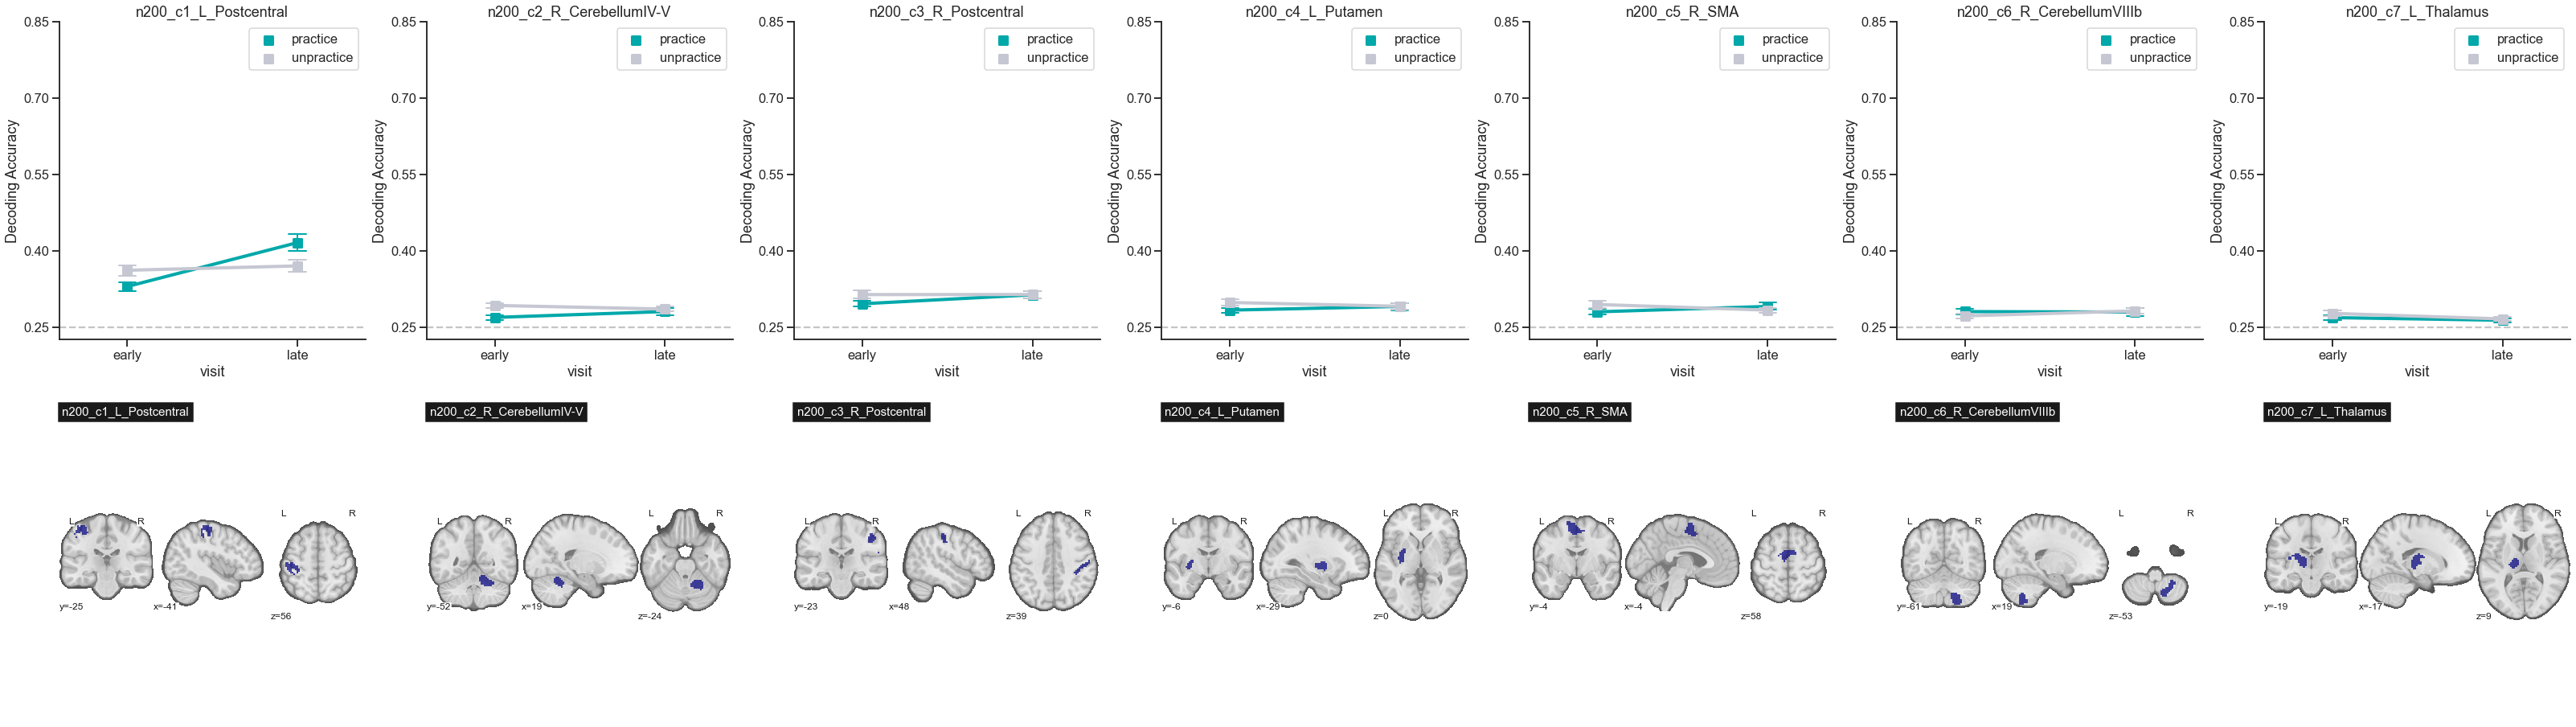

In [10]:
magn = 8   # a size of figures
ncol = 7   # a number of columns

nrow = 2*len(roi_imgs.keys())//ncol   # a number of rows
fig, axes = plt.subplots(nrow,ncol,figsize=(ncol*magn,nrow*magn))
for i, (key, img) in enumerate(roi_imgs.items()):
    print(key, end='\r')
    ax = GA.draw_lineplot(roi_name=key, title=key, ax=axes[2*(i//ncol),(i%ncol)])
    nplt.plot_roi(roi_img=img, bg_img=img_bg, title=key
                  , draw_cross=False, black_bg=False
                  , display_mode='ortho', axes=axes[2*(i//ncol)+1,(i%ncol)])

In [11]:
GA.do_paired_t_test('early_practice','late_practice')

{('n200_c1_L_Postcentral', 'early_practice/late_practice'): (array([ True]),
  array([8.27332221e-05])),
 ('n200_c2_R_CerebellumIV-V', 'early_practice/late_practice'): (array([False]),
  array([0.0722071])),
 ('n200_c3_R_Postcentral', 'early_practice/late_practice'): (array([False]),
  array([0.0639397])),
 ('n200_c4_L_Putamen', 'early_practice/late_practice'): (array([False]),
  array([0.39472756])),
 ('n200_c5_R_SMA', 'early_practice/late_practice'): (array([False]),
  array([0.1912762])),
 ('n200_c6_R_CerebellumVIIIb',
  'early_practice/late_practice'): (array([False]), array([0.92336231])),
 ('n200_c7_L_Thalamus', 'early_practice/late_practice'): (array([False]),
  array([0.41168924]))}

In [12]:
GA.make_wit_mean_ttest(stage='early_practice', mean=0.25)

,ROI,visit,mapping,tval,pval_uncorrected,reject,pval_corrected
0,n200_c1_L_Postcentral,early,practice,8.703611,1.394858e-09,True,1.394858e-09
1,n200_c2_R_CerebellumIV-V,early,practice,3.806147,6.754291e-04,True,6.754291e-04
2,n200_c3_R_Postcentral,early,practice,9.022293,6.455393e-10,True,6.455393e-10
3,n200_c4_L_Putamen,early,practice,6.371906,5.772277e-07,True,5.772277e-07
4,n200_c5_R_SMA,early,practice,5.639728,4.297449e-06,True,4.297449e-06
5,n200_c6_R_CerebellumVIIIb,early,practice,5.129903,1.767790e-05,True,1.767790e-05
6,n200_c7_L_Thalamus,early,practice,4.464133,1.121099e-04,True,1.121099e-04
